In [1]:
## python demo of RR Lyrae template fitter fit_template.R
## by james long
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector, BoolVector
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools

## set up rpy2 so we can call R functions
r=robjects.r
r.source("fit_template.R")
r.load("template_sdss.RData") ## loads r.tem, see later code for usage
FitTemplate=robjects.r['FitTemplate']
ComputeCoeffs=robjects.r['ComputeCoeffs']


In [2]:


###### FIT MODEL on SDSS Stripe 82 light curve

## load a light curve, put in nice format
fname="LC_402316.dat"
with open(fname) as csvf:
    f = csv.reader(csvf,delimiter=' ')
    time, band, mag, error = zip(*f)


no_pound = [not '#' in x for x in time]    
time = list(itertools.compress(time, no_pound))
band = list(itertools.compress(band, no_pound))
mag = list(itertools.compress(mag, no_pound))
error = list(itertools.compress(error, no_pound))


time = np.array(time,dtype='float64')
mag = np.array(mag,dtype='float64')
error = np.array(error,dtype='float64')

######## plot unfolded (raw light curve)
cols = {'u': 'blue', 'g': 'green', 'r':'red', 'i':'violet', 'z':'black'}
pts=plt.scatter(time,mag,color=list(map(cols.get,band)))
plt.gca().invert_yaxis()
plt.xlim([np.min(time),np.max(time)])
recs = []
for i in cols.values():
    recs.append(mpatches.Rectangle((0,0),1,1,fc=i))


plt.legend(recs,cols.keys(),loc=4)

plt.show()





In [ ]:
## create R dataframe using time,band,mag,error
lc = robjects.r['TBMEtoLC'](FloatVector(time),StrVector(band),FloatVector(mag),FloatVector(error))

# ###### fit model to lc
## choose frequency grid
omegas=FloatVector(np.arange(start=1.0,stop=2.5,step=0.1/4000.0))
## compute rss (residual sum of squares) for each frequency, takes a minute
rss=FitTemplate(lc,omegas,r.tem_sdss)
## select best fitting period, ie lowest rss
omega = omegas[np.argmin(rss)] ## best fit frequency
pest=1.0/omega ## best fit period
coeffs=ComputeCoeffs(lc,omega,r.tem_sdss) ## parameter estimates of best fit frequency
## the output is [distance modulus (mu),amount of dust (E[B-V]),amplitude (a),phase (rho)]
# >>> coeffs
# R object with classes: ('numeric',) mapped to:
# <FloatVector - Python:0x7f6ecca62088 / R:0x6c3bcf0>
# [19.250568, 0.044055, 1.225825, 0.172240]
# >>> omega
# 1.8413499999980392
# >>> pest
# 0.543079805578008



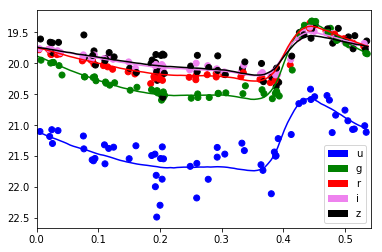

In [3]:
###### now plot results
## plot lightcurve folded on estimated period
pts=plt.scatter(np.mod(time,pest),mag,color=list(map(cols.get,band)))
plt.gca().invert_yaxis()
plt.xlim([0,pest])
recs = []
for i in cols.values():
    recs.append(mpatches.Rectangle((0,0),1,1,fc=i))

plt.legend(recs,cols.keys(),loc=4)

### add template fits manually
gamma = r.tem_sdss[1]
gamma = np.resize(gamma,(5,100))
t=(np.arange(100)/100.)*pest
ords=np.argsort((t - coeffs[3]*pest) % pest)
abs_mag = r.tem_sdss[7](pest,r.tem_sdss) ## get absolute magnitudes at pest
for ii in np.arange(gamma.shape[0]):
    m=coeffs[0] + abs_mag[ii] + r.tem_sdss[0][ii]*coeffs[1] + coeffs[2]*gamma[ii,:]
    plt.plot(t,m[ords],'k',color=cols[r.tem_sdss[0].names[ii]])

    
plt.show()



In [14]:


###### DUST CORRECT LIGHT CURVE AND FIT MODEL
###### WITHOUT DUST
###### obtain dust from schlegel dust map

## load a light curve, put in nice format
fname="LC_402316.dat"
with open(fname) as csvf:
    f = csv.reader(csvf,delimiter=' ')
    time, band, mag, error = zip(*f)

no_pound = [not '#' in x for x in time]    
time = list(itertools.compress(time, no_pound))
band = list(itertools.compress(band, no_pound))
mag = list(itertools.compress(mag, no_pound))
error = list(itertools.compress(error, no_pound))

## convert to floats
mag = list(map(float,mag))
time = list(map(float,time))
error = list(map(float,error))

## dust correct mag vector
schlegel_r = 0.108 ## extinction in r reported by schlegel for this lc
dust_dict = {list(r.tem_sdss[0].names)[i] : list(r.tem_sdss[0])[i] for i in range(5)}
ebv = schlegel_r / dust_dict['r'] ## convert to ebv

def DustCorrect(b,m): ## b is band, m is mag
    return m - ebv*dust_dict[b]

mag = list(map(DustCorrect, band, mag))


In [ ]:


## create R dataframe using time,band,mag,error
time = np.array(time,dtype='float64')
mag = np.array(mag,dtype='float64')
error = np.array(error,dtype='float64')
lc = robjects.r['TBMEtoLC'](FloatVector(time),StrVector(band),FloatVector(mag),FloatVector(error))


### fit model to lc with dust turned OFF
omegas=FloatVector(np.arange(start=1.0,stop=2.5,step=0.1/4000.0))
NN = IntVector(np.array([5],dtype='int'))
use_errors = BoolVector(np.array([True],dtype='bool'))
use_dust = BoolVector(np.array([False],dtype='bool'))
rss=FitTemplate(lc,omegas,r.tem_sdss,NN,use_errors,use_dust)
## select best fitting period, ie lowest rss
omega = omegas[np.argmin(rss)] ## best fit frequency
pest=1.0/omega ## best fit period
NN = IntVector(np.array([20],dtype='int'))
coeffs=ComputeCoeffs(lc,omega,r.tem_sdss,NN,use_errors,use_dust)  ## parameter estimates of best fit frequency
print(coeffs)
## the output is [distance modulus (mu),amount of dust (E[B-V]),amplitude (a),phase (rho)]
## E[B-V] = 0 because dust is off
# >>> coeffs
# R object with classes: ('numeric',) mapped to:
# <FloatVector - Python:0x7fad945a1ac8 / R:0x65cef18>
# [19.256907, 0.000000, 1.225244, 0.172226]
print(omega)
# >>> omega
# 1.8413499999980392
print(pest)
# >>> pest
# 0.543079805578008


In [ ]:



###### FIT MODEL on DES version of light curve
#### compare sloan / des fits on same RRL
r.load("template_des.RData") ## loads des template


## load des light curve, put in nice format
fname="LC_402316_des.dat"
with open(fname) as csvf:
    f = csv.reader(csvf,delimiter='\t')
    next(f,None)
    time, mag, error, band = zip(*f)

## get rid of suspicious data containing #
no_pound = [not '#' in x for x in time]    
time = list(itertools.compress(time, no_pound))
band = list(itertools.compress(band, no_pound))
mag = list(itertools.compress(mag, no_pound))
error = list(itertools.compress(error, no_pound))


time = np.array(time,dtype='float64')
mag = np.array(mag,dtype='float64')
error = np.array(error,dtype='float64')


## create R dataframe using time,band,mag,error
lc = robjects.r['TBMEtoLC'](FloatVector(time),StrVector(band),FloatVector(mag),FloatVector(error))

rss_des=FitTemplate(lc,omegas,r.tem)
## select best fitting period, ie lowest rss
omega_des = omegas[np.argmin(rss_des)] ## best fit frequency
## parameter estimates of best fit frequency, compare to sloan above
pest_des=1.0/omega_des ## best fit period
coeffs_des=ComputeCoeffs(lc,omega_des,r.tem) 
# >>> coeffs_des
# R object with classes: ('numeric',) mapped to:
# <FloatVector - Python:0x7fad945a9808 / R:0x5171668>
# [19.232691, 0.049118, 1.182909, 0.182078]

######## compare des and sloan estimates
## des estimates
pest_des
## sloan estimates
pest




